# Interpolation at the Gulf Stream

**Problem:** Integrating the \betaV term for the subtropical gyre within a closed streamfunction contour does not give zero.

**Issue:** The Gulf Stream's edge is not resolved well. 

**Solution:** Only taking part of the cell(s) that model the Gulf Stream using linear interpolation technique.

Success! 

In [1]:
import numpy as np
import xarray as xr
import xesmf as xe
from eofs.xarray import Eof
from eofs.examples import example_data_path
import xgcm
from sklearn import preprocessing
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.feature as cft
import cartopy.crs as ccrs
import cmocean as cm

from gsw import sigma2, SA_from_SP, p_from_z, rho

import cosima_cookbook as cc
import gcm_filters
import os

import cartopy.feature as cfeature

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)
warnings.simplefilter('ignore')

In [2]:
import dask
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38675,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:34971,Total threads: 4
Dashboard: /proxy/42867/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:32827,


In [3]:
start_time, end_time = '2041-01-01', '2080-12-31'
x_min, x_max = -100, 10
y_min, y_max = 10, 75
ρ0 = 1035

var_name = 'beta_v'
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']
expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']

In [4]:
base_dir = '/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/'
dir_name = 'Monthly_mean_BVB_MOM6-SIS2_RYF_control'

expt = 'mom6-om4-025-RYF-control'

db = '/scratch/x77/db6174/mom6/archive/databases/cc_database_RYF_control.db'
session = cc.database.create_session(db)

## Calculate barotropic streamfunction

In [5]:
umo_2d = cc.querying.getvar(expt, 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
vmo_2d = cc.querying.getvar(expt, 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))

grid_data = xr.merge((umo_2d, vmo_2d))
grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])
vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')

area_bu = cc.querying.getvar(expt, 'areacello_bu', session, frequency = 'static', n = 1).isel(xq = slice(1, None)).isel(yq = slice(1, None))
area_bu = area_bu * (vmo_2d_itp[0]/vmo_2d_itp[0])
area_bu_NA = area_bu.sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))

temp = cc.querying.getvar(expt, 'tos', session, frequency = '1 monthly', n = 1, chunks = {})
area = cc.querying.getvar(expt, 'areacello', session, frequency = 'static', n = 1)
area = area * (temp[0]/temp[0])
area_NA = area.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))

In [6]:
geolon = cc.querying.getvar(expt, 'geolon', session, frequency = 'static', n = 1)
geolat = cc.querying.getvar(expt, 'geolat', session, frequency = 'static', n = 1)

In [7]:
# Define the levels for the contourf
lvls = np.linspace(-80, 80, 41)

def psi_func(axes):

    ## Cell-centred x-directed mass transport vertically summed
    tx_trans_int_z = umo_2d.mean('time')
    
    ## 2-dimensional lat-lon grid
    geolon_t = geolon
    geolat_t = geolat
    
    ## Calculation of streamfunction from x-directed mass transport
    psi = -tx_trans_int_z.cumsum('yh')/(1e6*ρ0) # divide by 1e6 to convert m^3/s -> Sv
    psi_acc = np.nanmin(psi.sel(xq = slice(-69, -67), yh = slice(-80, -55)))
    psi_g = psi - psi_acc
    psi_g = psi_g.rename('psi')
    psi_g.attrs['long_name'] = 'Barotropic Streamfunction'
    psi_g.attrs['units'] = 'Sv'
    psi_g = psi_g.where(~np.isnan(tx_trans_int_z))
    
    ## Interpolating streamfunction to cell centre grid
    paths = []
    paths.append("/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7_RCP45/output120/ocean/ocean.nc")
    data = xr.merge((psi_g, geolat_t))
    data.coords['xq'].attrs.update(axis='X')
    data.coords['xh'].attrs.update(axis='X',c_grid_axis_shift=0.5)
    g = xgcm.Grid(data, periodic=['X'])
    psi_g = g.interp(psi_g, 'X')
    psi_g = psi_g.rename('psi')
    
    ## Plotting begins
    
    ## Plotting land and continent boundaries
    axes.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
    axes.gridlines(color = 'grey', linestyle = '--')
    
    ## Plotting global streamfunction
    cf = axes.contourf(psi_g.xh.values, psi_g.yh.values, (psi_g * np.sign(psi.yh)).values, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())
    
    ## Specifying colorbar attributes
    cbar = fig.colorbar(cf, ax = axes, orientation = 'vertical', shrink = 0.4, ticks = [-80, -40, 0, 40, 80], pad = 0.04)#, aspect = 25, fraction = 0.05)
    cbar.set_label('Transport (Sv)', fontsize = 8)
    cbar.ax.tick_params(labelsize = 8)
    
    return psi_g

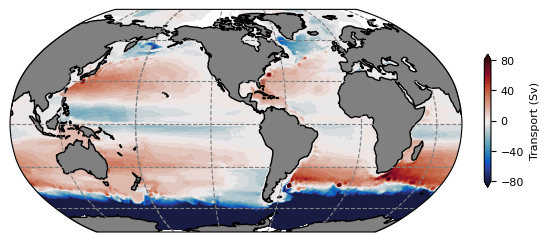

In [8]:
fig, ax1 = plt.subplots(figsize = (6*1.2, 3.6*1.2), subplot_kw = {'projection': ccrs.Robinson(central_longitude = 260)})
psi = psi_func(ax1)
ax1.set_title('')
psi_itp = grid.interp(psi, 'X')
psi_itp = grid.interp(psi_itp, 'Y')
psi_itp_NA = psi_itp.sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))

## Figure out cutoff contour

As an example, we consider the North Atlantic subtropical area where the barotropic streamfunction is greater than 10 Sv.

Text(0.5, 1.0, '10 Sv')

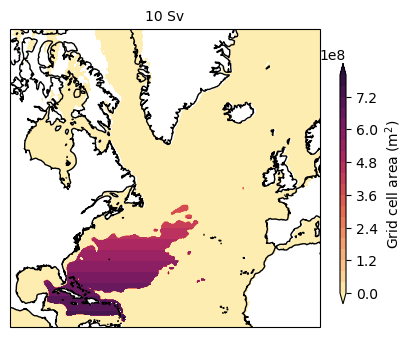

In [147]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), subplot_kw = {'projection': projection})

cutoff_contour = 10
mask = xr.where(psi_itp >=cutoff_contour, 1, 0)
temp = area_bu_NA * mask
p1 = axes.contourf(area_bu_NA.xq, area_bu_NA.yq, temp, levels = np.linspace(0, 8e8, 21), 
            cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.18, 0.015, 0.6])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Grid cell area (m$^2$)', fontsize = 10)

axes.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
axes.coastlines(resolution = '50m')
axes.set_title(str(cutoff_contour) + ' Sv', fontsize = 10)

## Naive calculations

In [148]:
beta_v = xr.open_dataset(base_dir + dir_name + '/141-180/' + 'beta_v' + '.nc')['beta_v'].sel(time = slice(start_time, end_time)).mean('time')

In [185]:
mask10 = xr.where(psi_itp >=cutoff_contour, 1, 0)
print('Integrated betaV for psi >= 10 Sv: ' + str((mask10 * area_bu_NA * beta_v).sum(['xq', 'yq']).values))
print('Integrated betaV for psi >= 10 Sv for 10-40 N (WBC latitudes only): ' + str((mask10 * area_bu_NA * beta_v.sel(yq = slice(10, 40))).sum(['xq', 'yq']).values))

Integrated betaV for psi >= 10 Sv: 481.771157353718
Integrated betaV for psi >= 10 Sv for 10-40 N (WBC latitudes only): 448.99967160583475


In [199]:
psi_itp_2 = ((vmo_2d_itp.sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min, y_max)).mean('time')/1e6/ρ0).cumsum('xq')).load()
mask10_2 = xr.where(psi_itp_2 >=cutoff_contour, 1, 0)

In [201]:
print('Integrated betaV for psi >= 10 Sv: ' + str((mask10_2 * area_bu_NA * beta_v).sel(yq = slice(None, 50)).sum(['xq', 'yq']).values))

Integrated betaV for psi >= 10 Sv: 265.55778394660575


Errors are huge! This integration should ideally be zero. We believe that these large values are linked to improper integration in regions where the streamfunction contour's spatial gradients are large. To test this, we redo our calculations for a single latitude range.

## Transects

In [150]:
beta_v_area = (beta_v * area_bu_NA).load()

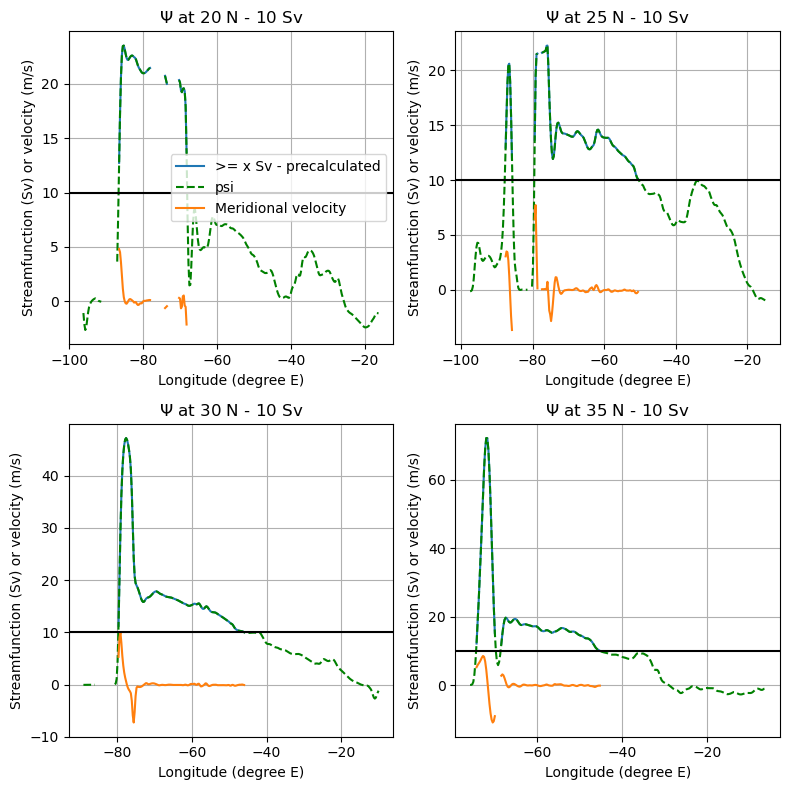

In [14]:
def psi_transect_plot_cumsum(row, col, cutoff, latitude):
    psi_itp.where(psi_itp >=cutoff).sel(yq = latitude, method = 'nearest').sel(xq = slice(-100, 0)).plot(label = '>= x Sv - precalculated', 
                                                                                                          ax = axes[row][col])
    psi_itp.sel(yq = latitude, method = 'nearest').sel(xq = slice(-100, 0)).plot(label = 'psi', ax = axes[row][col], color = 'green', ls = '--')
    (vmo_2d_itp.mean('time')/1e6/ρ0).where(psi_itp >=cutoff).sel(yq = latitude, method = 'nearest').sel(xq = slice(-100, 0)).plot(label = 'Meridional velocity', 
                                                                                                                      ax = axes[row][col])
    #((vmo_2d_itp.mean('time')/1e6/ρ0).where(psi_itp >=cutoff).sel(yq = latitude, method = 'nearest').sel(xq = slice(-100, 0)).cumsum(
    #    'xq') + cutoff_contour).plot(label = '>= x Sv - post masking v', ls = '--', ax = axes[row][col], color = 'red')
    axes[row][col].axhline(cutoff, color = 'black')
    axes[row][col].grid()
    axes[row][col].set_ylabel('Streamfunction (Sv) or velocity (m/s)')
    axes[row][col].set_xlabel('Longitude (degree E)')
    axes[row][col].set_title('$\Psi$ at ' + str(latitude) + ' N - ' + str(cutoff) + ' Sv')
    if(row == 0 and col == 0):
        axes[row][col].legend()

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 8))

psi_transect_plot_cumsum(0, 0, 10, 20)
psi_transect_plot_cumsum(0, 1, 10, 25)
psi_transect_plot_cumsum(1, 0, 10, 30)
psi_transect_plot_cumsum(1, 1, 10, 35)

plt.tight_layout()

The green dashed line shows the barotropic streamfunction calculated from before, while the blue line shows how our mask performs. Ideally, the blue line should overlap with the green dashed line for all longitudes as long as its value is greater than 10 Sv. However, we find large unaccounted flows, sometimes on the order of a few Sverdrups, especially in the western boundary. One solution to this issue is to recreate our mask and ensure partial values in these regions. 

## Taking 30 N as our test case and performing interpolation

In [151]:
def mask_with_GS_interpolation_transect(y_sel):

    Ψ = (vmo_2d_itp.sel(xq = slice(x_min, x_max)).sel(yq = y_sel, method = 'nearest').mean('time')/1e6/ρ0).cumsum('xq')
    Ψ_cutoff = Ψ.where(Ψ >=cutoff_contour).dropna('xq')
    x_east = Ψ_cutoff.xq[0]
    x_west = x_east - 0.25
    Ψ_east = Ψ.sel(xq = x_east, method = 'nearest').values
    Ψ_west = Ψ.sel(xq = x_west, method = 'nearest').values
    
    slope = (Ψ_east - Ψ_west)/(x_east - x_west)
    x_mid = x_east - (Ψ_east - cutoff_contour)/slope
    mask_fraction = (x_east - x_mid)/(x_east - x_west)
    old_mask = xr.where(Ψ >=cutoff_contour, 1, 0)
    new_mask = xr.where(old_mask.xq == x_east, mask_fraction, old_mask)

    return old_mask.drop('yq'), new_mask.drop('yq')

In [152]:
y_sel = 25
old_mask, new_mask = mask_with_GS_interpolation_transect(y_sel)

print((beta_v_area.sel(yq = y_sel, method = 'nearest') * old_mask).sum('xq').values)
print((beta_v_area.sel(yq = y_sel, method = 'nearest') * new_mask).sum('xq').values)

5.0854496751188805
4.152408551691041


Above, we tried to recreate our mask. The error is small but not zero. The reason is that the above function it only corrects the first gap it encounters. Other gaps can be created at the same latitude. For example, at around 25 N the western boundary is present in both the Gulf of Mexico and the Gulf Stream. The above function will not correct the erroneous flow in the Gulf Stream. 

## A bettet mask that takes (almost )all gaps

In [158]:
## One edge case remains, where the function encounters 3 alternating values, like 1, 0, 1.
## Another edge case is when the cutoff contour is close to zero.

old_mask = xr.where(Ψ >=cutoff_contour, 1, 0)
zero_precedes_one = np.where((old_mask.values[:-1] == 0) & (old_mask.values[1:] == 1))[0]
one_precedes_zero = np.where((old_mask.values[:-1] == 1) & (old_mask.values[1:] == 0))[0]

def mask_with_GS_interpolation_transect_all(Ψ, y_sel, zero_precedes_one, one_precedes_zero):

    old_mask = xr.where(Ψ >=cutoff_contour, 1, 0)
    Ψ_cutoff = Ψ.where(Ψ >=cutoff_contour).dropna('xq').load()
    if(Ψ_cutoff.shape[0] == 0):
        return old_mask, old_mask
    
    if(zero_precedes_one.shape[0] > 0):
        for i in zero_precedes_one:
            x_west = Ψ.xq[i]
            x_east = Ψ.xq[i+1]
            Ψ_east = Ψ.sel(xq = x_east, method = 'nearest').values
            Ψ_west = Ψ.sel(xq = x_west, method = 'nearest').values
            
            slope = (Ψ_east - Ψ_west)/(x_east - x_west)
            x_mid = x_east - (Ψ_east - cutoff_contour)/slope
            mask_fraction = (x_east - x_mid)/(x_east - x_west)
            if(i == zero_precedes_one[0]):
                new_mask = xr.where(old_mask.xq == x_east, mask_fraction, old_mask)
            else:
                new_mask = xr.where(old_mask.xq == x_east, mask_fraction, new_mask)

    if(one_precedes_zero.shape[0] > 0):
        for i in one_precedes_zero:
            x_west = Ψ.xq[i]
            x_east = Ψ.xq[i+1]
            Ψ_east = Ψ.sel(xq = x_east, method = 'nearest').values
            Ψ_west = Ψ.sel(xq = x_west, method = 'nearest').values
        
            slope = (Ψ_east - Ψ_west)/(x_east - x_west)
            x_mid = x_east - (Ψ_east - cutoff_contour)/slope
            mask_fraction = 1 - (x_east - x_mid)/(x_east - x_west)
            if(zero_precedes_one.shape[0] > 0):
                new_mask = xr.where(old_mask.xq == x_east, mask_fraction, new_mask)
            
            if(zero_precedes_one.shape[0] == 0 and i == one_precedes_zero.shape[0]):
                new_mask = xr.where(old_mask.xq == x_east, mask_fraction, old_mask)
            elif(zero_precedes_one.shape[0] == 0 and i!=one_precedes_zero.shape[0]):
                new_mask = xr.where(old_mask.xq == x_east, mask_fraction, new_mask)
            

    return old_mask, new_mask

Integration without interpolation: 5.0854496751188805
Integration with interpolation for all edge cases:-2.2044940455275865e-06


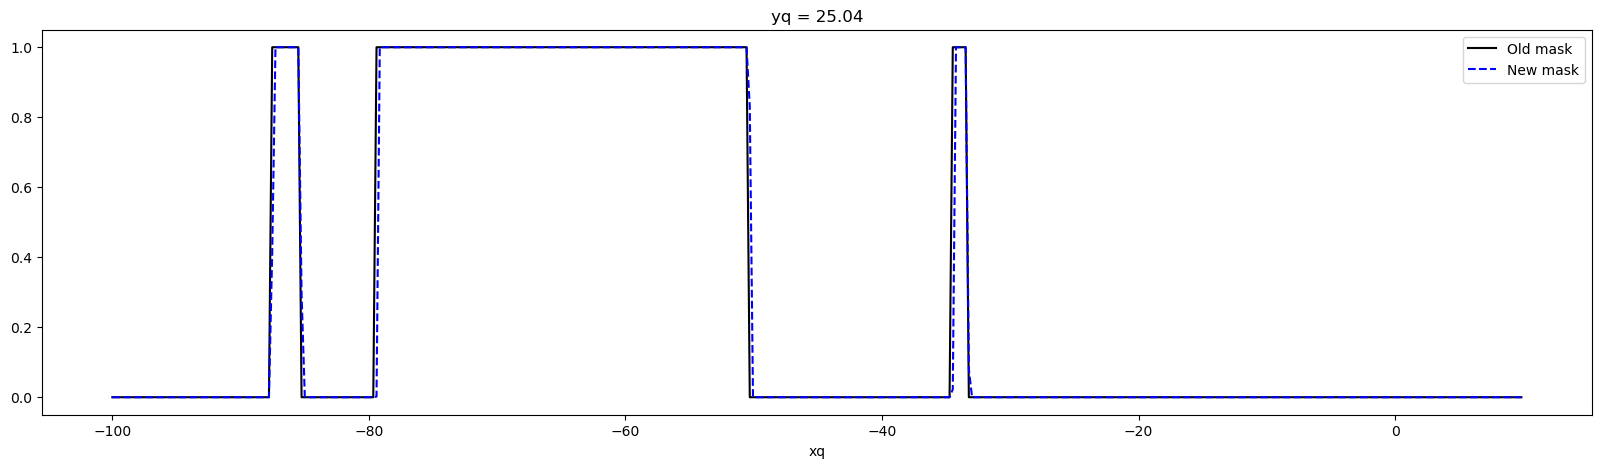

In [181]:
y_sel = 25
Ψ_ysel = ((vmo_2d_itp.sel(xq = slice(x_min, x_max)).sel(yq = y_sel, method = 'nearest').mean('time')/1e6/ρ0).cumsum('xq')).load()
old_mask = xr.where(Ψ_ysel >=cutoff_contour, 1, 0)
zero_precedes_one = np.where((old_mask.values[:-1] == 0) & (old_mask.values[1:] == 1))[0]
one_precedes_zero = np.where((old_mask.values[:-1] == 1) & (old_mask.values[1:] == 0))[0]
old_mask, new_mask = mask_with_GS_interpolation_transect_all(Ψ_ysel, y_sel, zero_precedes_one, one_precedes_zero)
print('Integration without interpolation: ' + str((beta_v_area.sel(yq = y_sel, method = 'nearest') * old_mask).sum('xq').values))
print('Integration with interpolation for all edge cases:' + str((beta_v_area.sel(yq = y_sel, method = 'nearest') * new_mask).sum('xq').values))

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 5))
old_mask.sel(xq = slice(None, None)).plot(ax = axes, color = 'black', label = 'Old mask')
new_mask.sel(xq = slice(None, None)).plot(ax = axes, color = 'blue', ls = '--', label = 'New mask')
plt.legend()

Considering the 25 N latitude again, this time we performed interpolations everywhere, including at the eastern boundaries, and we do get values quite close to zero!

## Beta-v for the entire North Atlantic subtropical gyre

In [188]:
βV_int1 = 0
βV_int2 = 0
beta_v_area = (beta_v * area_bu_NA).load()
Ψ = (vmo_2d_itp.sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min, y_max)).mean('time')/1e6/ρ0).cumsum('xq').load()

for y_sel in area_bu_NA.yq.sel(yq = slice(None, 50)).values:
    Ψ_ysel = Ψ.sel(yq = y_sel, method = 'nearest')
    old_mask = xr.where(Ψ_ysel >=cutoff_contour, 1, 0)
    zero_precedes_one = np.where((old_mask.values[:-1] == 0) & (old_mask.values[1:] == 1))[0]
    one_precedes_zero = np.where((old_mask.values[:-1] == 1) & (old_mask.values[1:] == 0))[0]

    old_mask, new_mask = mask_with_GS_interpolation_transect_all(Ψ_ysel, y_sel, zero_precedes_one, one_precedes_zero)
    βV_int1 = βV_int1 + (beta_v_area.sel(yq = y_sel, method = 'nearest') * old_mask).sum('xq').values
    βV_int2 = βV_int2 + (beta_v_area.sel(yq = y_sel, method = 'nearest') * new_mask).sum('xq').values
    if(y_sel == area_bu_NA.yq[0]):
        old_mask_total = old_mask
        new_mask_total = new_mask
    else:
        old_mask_total = xr.concat([old_mask_total, old_mask], dim = 'yq')
        new_mask_total = xr.concat([new_mask_total, new_mask], dim = 'yq')
print('Integrating without interpolation: :' + str(βV_int1))
print('Integrating with interpolation: :' + str(βV_int2))

Integrating without interpolation: :265.55778394660575
Integrating with interpolation: :-1.0865456920105144e-05


Much better!

## Other attempts - need further testing

In [14]:
mask10_subset = mask10.sel(xq = slice(-89, -33)).sel(yq = slice(11, 49))

In [ ]:
old_mask = mask10_subset.values

with open('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Repeat-year-forcing-setup/subtropical-gyre-pre.txt', 'w') as testfile:
    for row in old_mask:
        testfile.write(' '.join(str(old_mask) for old_mask in row) + '\n')

In [ ]:
file_path = '/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Repeat-year-forcing-setup/subtropical-gyre-post.txt'

with open(file_path, 'r') as file:
    lines = file.readlines()
    matrix = np.array([list(map(int, line.split())) for line in lines])

mask_without_blobs = xr.DataArray(matrix, coords = [mask10_subset.yq, mask10_subset.xq], dims = ['yq','xq'], name = 'mask', attrs = {'units':'none'})

In [ ]:
mask_without_blobs.plot()

In [ ]:
βV_int1 = 0
βV_int2 = 0
beta_v_area = (beta_v * area_bu_NA).load()
Ψ = (vmo_2d_itp.sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min, y_max)).mean('time')/1e6/ρ0).cumsum('xq').load()

for y_sel in area_bu_NA.yq.sel(yq = slice(None, 40)).values:
    Ψ_ysel = Ψ.sel(yq = y_sel, method = 'nearest')
    Ψ_cutoff = Ψ_ysel.where(Ψ_ysel >=cutoff_contour).dropna('xq')
    if(Ψ_cutoff.shape[0] > 0):
        x_east = Ψ_cutoff.xq[0]
        x_west = x_east - 0.25
        Ψ_east = Ψ_ysel.sel(xq = x_east, method = 'nearest').values
        Ψ_west = Ψ_ysel.sel(xq = x_west, method = 'nearest').values
        
        slope = (Ψ_east - Ψ_west)/(x_east - x_west)
        x_mid = x_east - (Ψ_east - cutoff_contour)/slope
        mask = mask_without_blobs.sel(yq = y_sel, method = 'nearest')
        mask_fraction = (x_east - x_mid)/(x_east - x_west)
        new_mask = xr.where(mask.xq == x_east, mask_fraction, mask)
        βV_int1 = βV_int1 + (beta_v_area.sel(yq = y_sel, method = 'nearest') * mask).sum('xq').values
        βV_int2 = βV_int2 + (beta_v_area.sel(yq = y_sel, method = 'nearest') * new_mask).sum('xq').values
    print('Integrating without interpolation: :' + str(βV_int1))
    print('Integrating with interpolation: :' + str(βV_int2))

In [ ]:
mask